<a href="https://colab.research.google.com/github/chltjs1921/2024_modeling_practice/blob/main/NeoAntigen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import json
import numpy as np
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
neo = pd.read_csv('/content/drive/MyDrive/FastCampus/Medical/Part 3/실습/NeoAntigen_dataset_for_training.csv')
neo

,antigen,allele_name,full_seq,pseudo_seq,label
0,EVMPVSMAK,HLA-A*11:01,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,1.0
1,ATFSVPMEK,HLA-A*11:01,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,1.0
2,RVFNNYMPY,HLA-A*11:01,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,1.0
3,ATVVIGTSK,HLA-A*11:01,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,1.0
4,SSNVANYQK,HLA-A*11:01,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,1.0
...,...,...,...,...,...
62643,SYIDRLAPR,HLA-A*33:03,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWY,1.0
62644,VVAAVRWRR,HLA-A*33:03,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWY,1.0
62645,YVFPKPFNR,HLA-A*33:03,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWY,1.0
62646,YVQRFHYSR,HLA-A*33:03,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWY,1.0


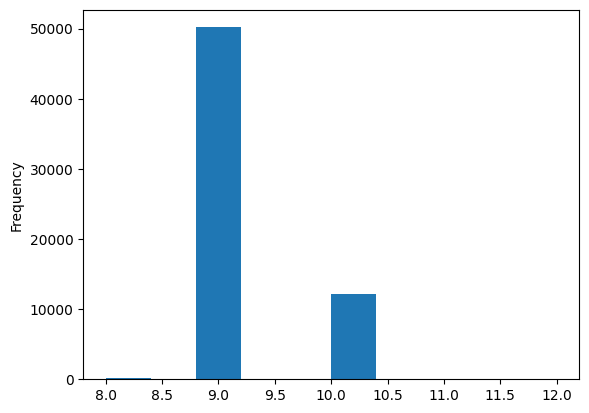

In [ ]:
neo['antigen'].apply(lambda x:len(x)).plot.hist()
max_seq_epitopes = neo['antigen'].apply(lambda x:len(x)).max()

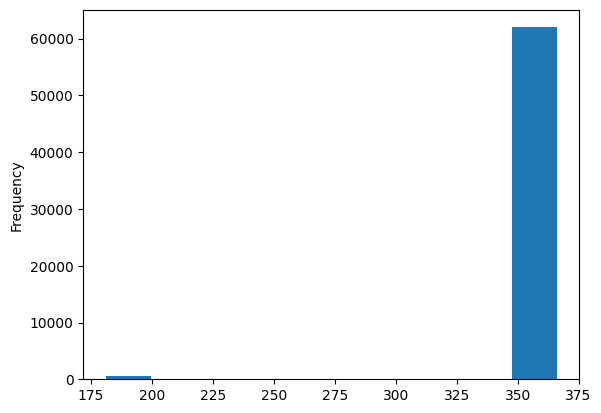

In [ ]:
neo['full_seq'].apply(lambda x:len(x)).plot.hist()
max_seq_full = neo['full_seq'].apply(lambda x:len(x)).max()

In [ ]:
!pip install subword_nmt

In [ ]:
from subword_nmt.apply_bpe import BPE

In [ ]:
amino_char = ['?', 'A', 'C', 'B', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'O',
       'N', 'Q', 'P', 'S', 'R', 'U', 'T', 'W', 'V', 'Y', 'X', 'Z']

# protein, drug 원핫(one-hot) 인코더
enc_protein = OneHotEncoder().fit(np.array(amino_char).reshape(-1, 1))

In [ ]:
def trans_protein(x, max_seq_protein):
    temp = list(x.upper())
    temp = [i if i in amino_char else '?' for i in temp]

    if len(temp) < max_seq_protein:
        temp += ['?'] * (max_seq_protein - len(temp))
    else:
        temp = temp[:max_seq_protein]

    return temp

In [ ]:
vocab_path = '/content/drive/MyDrive/FastCampus/Medical/Part 3/실습/protein_codes_uniprot_2000.txt'
bpe_codes_protein = open(vocab_path)
pbpe = BPE(bpe_codes_protein, merges=-1, separator='')
sub_csv = pd.read_csv('/content/drive/MyDrive/FastCampus/Medical/Part 3/실습/subword_units_map_uniprot_2000.csv')

In [ ]:
full_seq = pd.Series(neo['full_seq'])[0]
print(full_seq)
print(pbpe.process_line(full_seq))

MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEDGSHTIQIMYGCDVGPDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAAHAAEQQRAYLEGRCVEWLRRYLENGKETLQRTDPPKTHMTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPAGDGTFQKWAAVVVPSGEEQRYTCHVQHEGLPKPLTLRWELSSQPTIPIVGIIAGLVLLGAVITGAVVAAVMWRRKSSDRKGGSYTQAASSDSAQGSDVSLTACKV
MAV MAP RT LL LLL SG ALAL TQ TW AGS HS MRY FY TS VS RPG RG EP RF I AVG Y VDD TQ FVR F DSD AAS QR ME PR AP WIE QEG PE Y WD QE TR NVK AQ SQ TD RV DLG TL RG YY NQ SE DGS HT IQ IM YG CD VG PDG RFL RG YR QD AY DG KD YI ALNE DL RS W TAA DM AAQ IT KR K WE AA H AAE QQ R AYL EG RC VE WL RR YLE NG KETL QR TD PP KT HM TH HP ISD HE ATL RC W ALG FYP AE ITL TW QR DG ED QT QD TEL VE TR PAG DG TF QK WAA VV VP SG EE QR YT CH VQ HE GL PK PLTL RW ELSS QP TIP IVG II AGL VLLG AV ITG AV VAA VM WRR KSS D RK GG SY TQ AASS DS AQG SD VSL TAC K V


In [ ]:
idx2word_p = sub_csv['index'].values
word2idx_p = dict(zip(idx2word_p, range(0, len(idx2word_p))))

In [ ]:
def hla2emb_encoder(x):
    t1 = pbpe.process_line(x).split()
    try:
        i1 = np.asarray([word2idx_p[i] for i in t1])
    except:
        i1 = np.asarray([0])

    l = len(i1)

    if l < max_seq_full:
        i = np.pad(i1, (0, max_seq_full - l), 'constant', constant_values=0)
        input_mask = ([1] * l) + ([0] * (max_seq_full - l))
    else:
        i1 = i1[:max_seq_full]
        input_mask = [1] * max_seq_full
    return i, np.asarray(input_mask)

In [ ]:
t1 = pbpe.process_line(full_seq).split()

try:
    i1 = np.asarray([word2idx_p[i] for i in t1])
except:
    i1 = np.asarray([0])

i1

array([ 873, 1560,  159,   25,  194,   45, 1701,  172,  347,  482,  158,
       2934,  204,   94,   64,  806,   78,  249,  153,   22,  326,   12,
        789,  172, 1382,    3,  971,  381,  136,  137,  260,   83, 2360,
        730,   65,   12,  331,  104,  135, 1307,   72,  276,  127,  200,
        352,   35,   78,  250,  288,   88,  589,  297,  144,  293,  108,
        303,   58, 1015,  786,   78,  257,  156,  114,   73,  112,  325,
       3850,   36,  107,   23,  443,  360,  975,   79,  110,   15,  302,
         26,   24,  332,   98,   18,  425,  146,  370,   54,  145,   61,
        800,   81, 3239,  136,  127,  115,  116,  590,  215,  175,  835,
        170,  274,  370,   23,  251, 2778,   43,  686,  347,  136,   73,
        191,  205,  156,  666,   54,  135,  983,   73,  147,  196, 1940,
         42,   90,   45,   34,  136,  272,  496,  120,  170,   29,  280,
       3403,  372, 3357,  163, 1254,  558,  122,  218, 2673,   39,  696,
         39,  299,  155, 2164,  659,   21,  168,   

In [ ]:
def create_fold(df, fold_seed, frac):
    train_frac, val_frac, test_frac = frac

    test = df.sample(frac=test_frac, random_state=fold_seed, replace=False)
    train_val = df.drop(test.index)

    val = train_val.sample(frac=val_frac / (train_frac + val_frac), random_state=fold_seed, replace=False)
    train = train_val.drop(val.index)

    return train, val, test

In [ ]:
def process_data(df, seed, frac):

    AA = pd.Series(df['antigen'].unique()).apply(lambda x: trans_protein(x, max_seq_epitopes))
    AA_dict = dict(zip(df['antigen'].unique(), AA.values))
    df['antigen_preprocessed'] = [AA_dict[i] for i in df['antigen']]

    HLA = pd.Series(df['full_seq'].unique()).apply(lambda x: hla2emb_encoder(x))
    HLA_dict = dict(zip(df['full_seq'].unique(), HLA.values))
    df['full_seq_preprocessed'] = [HLA_dict[i] for i in df['full_seq']]

    train, val, test = create_fold(df, seed, frac)

    return train, val, test

In [ ]:
train, val, test = process_data(neo, 42, [0.7, 0.1, 0.2])

In [ ]:
def protein_2_embed(x):
    return enc_protein.transform(np.array(x).reshape(-1, 1)).toarray().T

In [ ]:
class data_preprocess_loader(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        v_e = self.df.iloc[idx]['antigen_preprocessed']
        v_e = protein_2_embed(v_e)

        v_f = self.df.iloc[idx]['full_seq_preprocessed']

        y = self.df.iloc[idx]['label']

        return v_e, v_f, y

In [ ]:
train_dataset = data_preprocess_loader(train)
val_dataset = data_preprocess_loader(val)
test_dataset = data_preprocess_loader(test)

In [ ]:
for (v_e, v_f, y) in train_dataset:
    print(v_e.shape, v_f[0].shape, v_f[1].shape, y)
    break

(26, 12) (366,) (366,) 1.0


In [ ]:
params = {'batch_size': 256,
            'shuffle': True,
            'num_workers': 1,
            'drop_last': False}

In [ ]:
train_generator = DataLoader(train_dataset, **params)
val_generator = DataLoader(val_dataset, **params)
test_generator = DataLoader(test_dataset, **params)

In [ ]:
for (v_e, v_f, y) in train_generator:
    print(v_e.shape, v_f[0].shape, v_f[1].shape, y)
    break

torch.Size([256, 26, 12]) torch.Size([256, 366]) torch.Size([256, 366]) tensor([0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
        0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 

In [ ]:
config = {
    # epitope 설정 (CNN)
    "cnn_epitope_filters" : [32,64,96],
    "cnn_epitope_kernels" : [3,3,3],
    'hidden_dim_epitope': 128,
    'max_seq_epitope' : max_seq_epitopes,

    # HLA (tranformer)
    'input_dim_hla': 4114, # subword vocab 크기
    'hidden_dim_hla': 64, # transformer embedding 크기
    'transformer_attention_probs_dropout': 0.1, # self-attention 연산 과정에서 적용되는 dropout
    'transformer_dropout_rate': 0.1, # word embedding - layer norm 이 후 적용되는 dropout
    'transformer_emb_size': 64, # word embedding 후 크기
    'transformer_hidden_dropout_rate': 0.1, # MLP에서 적용되는 dropout
    'transformer_intermediate_size': 256, # self-attention 이 후 MLP
    'transformer_n_layer': 2, # transformer 인코더 개수
    'transformer_num_attention_heads': 4, # self attention 시 head 개수

    # classifier
    'cls_hidden_dims': [1024, 1024, 512],
    }

In [ ]:
class CNN(nn.Sequential):
    def __init__(self, encoding, **config):
        super(CNN, self).__init__()

        in_ch = [26] + config[f'cnn_{encoding}_filters']
        kernels = config[f'cnn_{encoding}_kernels']
        layer_size = len(config[f'cnn_{encoding}_filters'])

        self.conv = nn.ModuleList([nn.Conv1d(in_ch[i], in_ch[i+1], kernels[i]) for i in range(layer_size)]).double()

        max_seq = config[f'max_seq_{encoding}']
        n_size_d = self._get_conv_output((26, max_seq))
        self.fc1 = nn.Linear(n_size_d, config[f'hidden_dim_{encoding}'])

    def _get_conv_output(self, shape):
        batch_size = 1
        input = Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(input.double())
        n_size = output_feat.data.view(batch_size, -1).size(1)

        return n_size

    def _forward_features(self, x):
        for l in self.conv:
            x = F.relu(l(x))
        x = F.adaptive_max_pool1d(x, output_size=1)
        return x

    def forward(self, x):
        x = self._forward_features(x.double())
        x = x.view(x.size(0), -1)
        x = self.fc1(x.float())
        return x

In [ ]:
import copy
import math
import collections

In [ ]:
class LayerNorm(nn.Module):
    """word embedding 이 후 적용되는 layer normalization
    """
    def __init__(self, hidden_size, variance_epsilon=1e-12):
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.weight * x + self.bias

In [ ]:
class Embeddings(nn.Module):
    """word embedding
    """
    def __init__(self, vocab_size, hidden_size, max_position_size, dropout_rate):
        super(Embeddings, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_position_size, hidden_size)

        self.LayerNorm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        embeddings = words_embeddings + position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

In [ ]:
class SelfAttention(nn.Module):
    """self-attention"""
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob):
        super(SelfAttention, self).__init__()
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, num_attention_heads))

        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size

        self.query = nn.Linear(hidden_size, self.all_head_size)
        self.key = nn.Linear(hidden_size, self.all_head_size)
        self.value = nn.Linear(hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask):
        # 모든 head의 query, key, value matrix 한번에 생성하기
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # 헤드 별로 qurey, key, value matrix 나누기
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # query, key matrix 곱으로 attention scores 구하기
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        # attention_head_size로 scaling
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # attention mask 값 더하기 (masking 할 부분에 매우 작은 음수 값 더해주기)
        attention_scores = attention_scores + attention_mask

        # softmax를 이용하여 attention score [0,1]의 값으로 만들기
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # self attention 이 후 dropout
        attention_probs = self.dropout(attention_probs)

        # [0,1]의 attention score로 각 토큰 value의 가중합 구하기
        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous() # (batch_size x vocab_size x num_attention_heads x attention_head_size)
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,) # (batch_size x vocab_size x all_head_size)
        context_layer = context_layer.view(*new_context_layer_shape)

        return context_layer

In [ ]:
class SelfOutput(nn.Module):
    def __init__(self, hidden_size, hidden_dropout_prob):
        super(SelfOutput, self).__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

In [ ]:
class Attention(nn.Module):
    """Self attention + MLP
    """
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Attention, self).__init__()
        self.self_attention = SelfAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob)
        self.self_output = SelfOutput(hidden_size, hidden_dropout_prob)

    def forward(self, input_tensor, attention_mask):
        self_output = self.self_attention(input_tensor, attention_mask)
        attention_output = self.self_output(self_output, input_tensor)
        return attention_output

In [ ]:
class Intermediate(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        super(Intermediate, self).__init__()
        self.dense = nn.Linear(hidden_size, intermediate_size)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = F.relu(hidden_states)
        return hidden_states

In [ ]:
class Output(nn.Module):
    def __init__(self, intermediate_size, hidden_size, hidden_dropout_prob):
        super(Output, self).__init__()
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Encoder, self).__init__()
        self.attention = Attention(hidden_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob)
        self.intermediate = Intermediate(hidden_size, intermediate_size)
        self.output = Output(intermediate_size, hidden_size, hidden_dropout_prob)

    def forward(self, hidden_states, attention_mask):
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

In [ ]:
class Encoder_MultipleLayers(nn.Module):
    def __init__(self, n_layer, hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Encoder_MultipleLayers, self).__init__()
        layer = Encoder(hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob)
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(n_layer)])

    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):
        all_encoder_layers = []
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)
            #if output_all_encoded_layers:
            #    all_encoder_layers.append(hidden_states)
        #if not output_all_encoded_layers:
        #    all_encoder_layers.append(hidden_states)
        return hidden_states

In [ ]:
class transformer(nn.Sequential):
    def __init__(self, encoding, **config):
        super(transformer, self).__init__()

        if encoding == 'hla':
            self.emb = Embeddings(config['input_dim_hla'], config['transformer_emb_size'], 366, config['transformer_dropout_rate'])
            self.encoder = Encoder_MultipleLayers(config['transformer_n_layer'],
                                                  config['transformer_emb_size'],
                                                  config['transformer_intermediate_size'],
                                                  config['transformer_num_attention_heads'],
                                                  config['transformer_attention_probs_dropout'],
                                                  config['transformer_hidden_dropout_rate'])

    def forward(self, v):
        e = v[0].long().to(device) # subword encoding 된 input
        e_mask = v[1].long().to(device) # masking table (0 또는 1 값만 가짐)
        ex_e_mask = e_mask.unsqueeze(1).unsqueeze(2)
        ex_e_mask = (1.0 - ex_e_mask) * -10000.0 # (if 0 -> 매우 작은 음수 값, else -> 0 )

        emb = self.emb(e) # word embedding - postional encodding - layer normalization 진행
        encoded_layers = self.encoder(emb.float(), ex_e_mask.float()) # self-attention block + MLP embedding layer
        return encoded_layers[:,0]

In [ ]:
class Classifier(nn.Sequential):
    def __init__(self, model_epitope, model_hla, **config):
        super(Classifier, self).__init__()

        self.input_dim_epitope = config['hidden_dim_epitope']
        self.input_dim_hla = config['hidden_dim_hla']
        self.model_epitope = model_epitope
        self.model_hla = model_hla

        self.dropout = nn.Dropout(0.1)

        self.hidden_dims = config['cls_hidden_dims']
        layer_size = len(self.hidden_dims)
        dims = [self.input_dim_epitope + self.input_dim_hla] + self.hidden_dims + [1]
        self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])

    def forward(self, v_e, v_f):
        v_E = self.model_epitope(v_e)
        v_H = self.model_hla(v_f)

        v_f = torch.cat([v_E, v_H], dim=1)

        for i, l in enumerate(self.predictor):
            if i == (len(self.predictor) - 1):
                v_f = l(v_f)
            else:
                v_f = self.dropout(F.relu(l(v_f)))

        return v_f



In [ ]:
model_epitope = CNN('epitope', **config)

In [ ]:
model_hla = transformer('hla', **config)

In [ ]:
model = Classifier(model_epitope, model_hla, **config)

In [ ]:
model = model.to(device)

In [ ]:
from prettytable import PrettyTable
from time import time

from sklearn.metrics import mean_squared_error, roc_auc_score, average_precision_score, f1_score, log_loss

In [ ]:
learning_rate = 0.001
weight_decay  = 0.00001
train_epoch   = 20

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

loss_fn = nn.BCELoss()

sigmoid = nn.Sigmoid()

In [ ]:
def get_metrics(y_label, y_pred):
    auc = roc_auc_score(y_label, y_pred)
    ap = average_precision_score(y_label, y_pred)
    f1 = f1_score(y_label, y_pred)
    loss = log_loss(y_label, y_pred)

    return auc, ap, f1, loss

In [ ]:
loss_history = []

max_auc = 0
model_max = copy.deepcopy(model)

valid_metric_record = [] # 각 metrics 저장
valid_metric_header = ["# epoch", "AUROC", "AUPRC", "F1", "log_loss"]

table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0,4f'%x

In [ ]:
loss_history = []

max_auc = 0 # 최고 AUC 저장
model_max = copy.deepcopy(model) # 최고 AUC 저장

float2str = lambda x:'%0.4f'%x  # float 자료 형 str로 만들기 (소숫점 4자리까지)

print('--- Go for Training ---')
t_start = time()


for epoch in range(train_epoch):
    # Training
    model.train()

    for i, (v_d, v_p, label) in enumerate(train_generator):
        v_p = tuple(map(lambda x: x.float().to(device), v_p))
        v_d = v_d.float().to(device)

        # 순전파 (forward-pass)
        score = model(v_d, v_p)
        label = Variable(torch.from_numpy(np.array(label)).float()).to(device) # label numpy -> torch tensor

        # 모델 아웃풋 score -> probability
        n = torch.squeeze(sigmoid(score), 0)

        label = label.view(-1, 1).repeat(1, n.shape[1])

        # 손실 값(loss) 계산
        loss = loss_fn(n, label)
        loss_history.append(loss.item()) # loss 기록

        opt.zero_grad() # gradient 초기화
        loss.backward() # back propagation
        opt.step() # parameter 업데이트

    # Validation
    model.eval()
    with torch.set_grad_enabled(False):
        y_pred = []
        y_label = []

        for i, (v_d, v_p, label) in enumerate(val_generator):
            v_p = tuple(map(lambda x: x.float().to(device), v_p))
            v_d = v_d.float().to(device)

            # 순전파 (forward-pass)
            score = model(v_d, v_p)

            logits = torch.squeeze(sigmoid(score)).detach().cpu().numpy() # 예측 확률
            label_ids = label.to('cpu').numpy() # 참 값

            y_label.extend(label_ids.flatten().tolist())  # Use extend instead of +
            y_pred.extend(np.mean(logits, axis=1).tolist())

    # 예측 값
    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])

    # model evaluation
    auc, auprc, f1, lloss = get_metrics(y_label, outputs)

    lst = ["epoch " + str(epoch)] + list(map(float2str,[auc, auprc, f1, lloss]))
    valid_metric_record.append(lst)

    if auc > max_auc:
        # 이전 epoch 보다 AUC 좋아지면 model_max, max_auc 갱신
        model_max = copy.deepcopy(model)
        max_auc = auc

    print('Validation at Epoch '+ str(epoch + 1) + ', AUROC: ' + str(auc)[:7] + \
            ' , AUPRC: ' + str(auprc)[:7] + ' , F1: '+str(f1)[:7] + ' , Cross-entropy Loss: ' + \
            str(lloss)[:7])


    table.add_row(lst)

--- Go for Training ---
Validation at Epoch 1, AUROC: 0.86480 , AUPRC: 0.69918 , F1: 0.80338 , Cross-entropy Loss: 3.60724
Validation at Epoch 2, AUROC: 0.85723 , AUPRC: 0.69184 , F1: 0.79567 , Cross-entropy Loss: 3.69929
Validation at Epoch 3, AUROC: 0.87452 , AUPRC: 0.65605 , F1: 0.78513 , Cross-entropy Loss: 4.42419
Validation at Epoch 4, AUROC: 0.86804 , AUPRC: 0.71259 , F1: 0.81141 , Cross-entropy Loss: 3.42314
Validation at Epoch 5, AUROC: 0.87783 , AUPRC: 0.70336 , F1: 0.81197 , Cross-entropy Loss: 3.57847
Validation at Epoch 6, AUROC: 0.86106 , AUPRC: 0.71103 , F1: 0.80659 , Cross-entropy Loss: 3.44039
Validation at Epoch 7, AUROC: 0.87593 , AUPRC: 0.71496 , F1: 0.81674 , Cross-entropy Loss: 3.40012
Validation at Epoch 8, AUROC: 0.86067 , AUPRC: 0.69309 , F1: 0.79823 , Cross-entropy Loss: 3.68778
Validation at Epoch 9, AUROC: 0.84961 , AUPRC: 0.70730 , F1: 0.79746 , Cross-entropy Loss: 3.49217
Validation at Epoch 10, AUROC: 0.87955 , AUPRC: 0.69873 , F1: 0.81037 , Cross-entropy

In [ ]:
model = model_max
model.eval()

y_pred_test = []
y_label_test  = []
y_outputs_test  = []

for i, (v_d, v_p, label) in enumerate(test_generator):
    v_p = tuple(map(lambda x: x.float().to(device), v_p))
    v_d = v_d.float().to(device)

    score = model(v_d, v_p)

    logits = torch.squeeze(sigmoid(score)).detach().cpu().numpy() # 예측 확률
    label_ids = label.to('cpu').numpy() # 참 값

    y_label_test.extend(label_ids.flatten().tolist())  # Use extend instead of +
    y_pred_test.extend(np.mean(logits, axis=1).tolist())

# Calculate outputs outside the loop to avoid repeated extension
outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred_test) >= 0.5)]) # Use y_pred_test here
y_outputs_test.extend(outputs)

auc, auprc, f1, lloss = get_metrics(y_label_test, y_outputs_test)

print('Test result - ' + ', AUROC: ' + str(auc)[:7] + ' , AUPRC: ' + str(auprc)[:7] + ' , F1: '+str(f1)[:7] + ' , Cross-entropy Loss: ' + str(lloss)[:7])

Test result - , AUROC: 0.87708 , AUPRC: 0.71201 , F1: 0.81591 , Cross-entropy Loss: 3.37999


In [ ]:
def roc_curve(y_pred, y_label, figure_file, method_name):
	'''ROC 커브 그리기

	Args:
		y_pred: 예측 확률 값이 담긴 리스트 [0,1]
		y_label: 참 값 (0/1)
	'''

	import matplotlib.pyplot as plt
	from sklearn.metrics import roc_curve, auc
	from sklearn.metrics import roc_auc_score

	y_label = np.array(y_label)
	y_pred = np.array(y_pred)

	fpr = dict()
	tpr = dict()
	roc_auc = dict()

	fpr[0], tpr[0], _ = roc_curve(y_label, y_pred) # FPR / TPR 구하기
	roc_auc[0] = auc(fpr[0], tpr[0]) # AUC 구하기

	# ROC 커브 그리기
	lw = 2
	plt.plot(fpr[0], tpr[0],
         lw=lw, label= method_name + ' (area = %0.2f)' % roc_auc[0])
	plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	fontsize = 14
	plt.xlabel('False Positive Rate', fontsize = fontsize)
	plt.ylabel('True Positive Rate', fontsize = fontsize)
	plt.title('Receiver Operating Characteristic Curve')
	plt.legend(loc="lower right")
	plt.savefig(figure_file)


def prauc_curve(y_pred, y_label, figure_file, method_name):
	'''Precision-Recall 커브 그리기

	Args:
		y_pred: 예측 확률 값이 담긴 리스트 [0,1]
		y_label: 참 값 (0/1)
	'''
	import matplotlib.pyplot as plt
	from sklearn.metrics import precision_recall_curve, average_precision_score
	from sklearn.metrics import f1_score
	from sklearn.metrics import auc

	lr_precision, lr_recall, _ = precision_recall_curve(y_label, y_pred) # precision, recall 구하기

	# 커브 그리기
	plt.plot(lr_recall, lr_precision, lw = 2, label= method_name + ' (area = %0.2f)' % average_precision_score(y_label, y_pred))
	fontsize = 14
	plt.xlabel('Recall', fontsize = fontsize)
	plt.ylabel('Precision', fontsize = fontsize)
	plt.title('Precision Recall Curve')
	plt.legend()
	plt.savefig(figure_file)

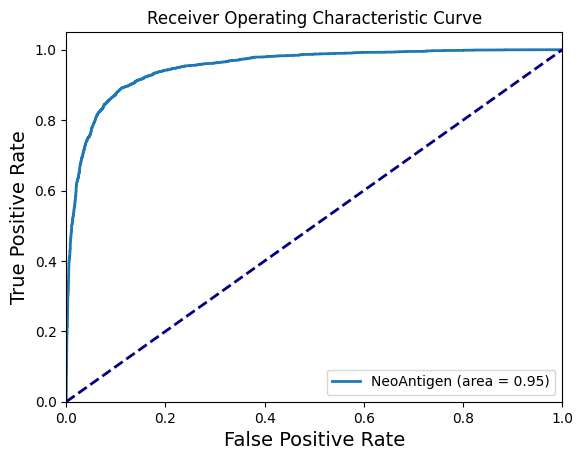

In [ ]:
roc_curve(y_pred_test, y_label_test, "NeoAntigen.png", "NeoAntigen")

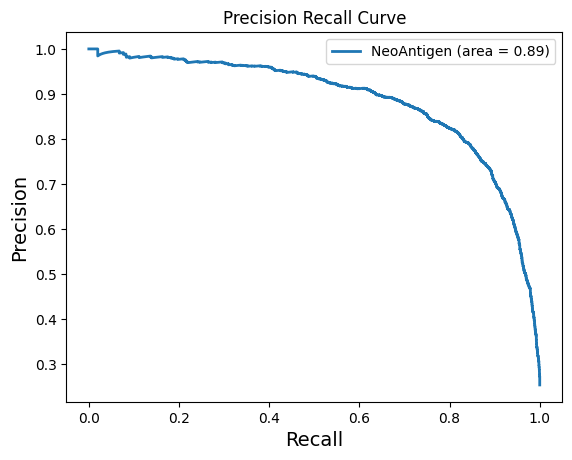

In [ ]:
prauc_curve(y_pred_test, y_label_test, "NeoAntigen.png", "NeoAntigen")